In [3]:
import numpy as np
from numpy.fft import *
import os
from numba import jit, njit, types, vectorize
import matplotlib.pyplot as plt
from scipy import stats

**Define functions for simulating spatial games:**


In [4]:
'''
Optimized/vectorized simulation code via Numba
'''
@vectorize(nopython=True)
def vec_pbc_reset(item, L):
    if item >= L:
        return 0
    elif item < 0:
        return L + item
    else:
        return item
    
@njit # better give non-arrary like inputs, otherwise do vectorization!
def spatial_game(x0, A11, A12, A21, A22,\
                 L = 256, dt = 0.01, num_iter = 500): # default parameters come after non-default parameters ... 
    
    N = L**2 # number of site
    moves = np.array([[-1,0],[1,0],[0,-1], [0,1]]) # adjacent move
    
    # creat initial configuration
    x = np.random.choice(2, (L,L), [x0, 1 - x0])
    
    # create a huge matrix to save all the results
    # (that's only way I can think to compromise with using numba .. )
    saver = np.zeros((num_iter, L, L)) 
    
    for i in range(num_iter):        
        for j in range(N): # play N games
            
            foc_pos = np.random.choice(L, (1,2))[0] # randomly choose a focal palyer
            foc_id = x[foc_pos[0],foc_pos[1]] # state of this focal player
            
            opp_pos = vec_pbc_reset(foc_pos + moves[np.random.choice(4)], L) # randomly choose an opponent 
            opp_id = x[opp_pos[0],opp_pos[1]]
            
            if foc_id == 0 and opp_id == 0:
                payoff = A11
            elif foc_id == 0 and opp_id == 1:
                payoff = A12
            elif foc_id == 1 and opp_id == 0:
                payoff = A21
            else:
                payoff = A22
                
            if payoff > 0:
                if np.random.uniform(0, 1) < payoff*dt:
                    rep_pos = vec_pbc_reset(foc_pos + moves[np.random.choice(4)], L) # the site to reproduce
                    rep_id = x[rep_pos[0],rep_pos[1]]  
                    x[rep_pos[0],rep_pos[1]] = foc_id # reproduce
                                        
            elif payoff < 0:
                if np.random.uniform(0, 1) < np.abs(payoff)*dt:
                    rep_pos = vec_pbc_reset(foc_pos + moves[np.random.choice(4)],L)
                    rep_id = x[rep_pos[0],rep_pos[1]] 
                    x[foc_pos[0],foc_pos[1]] = x[rep_pos[0],rep_pos[1]]
                    
        saver[i] = x 

    return saver

**Define functions for spatial analysis:**


In [5]:
'''
Standard numpy (fft doesn't support numba) for spatial analysis
'''
def moving_average(a, n): 
    '''
    a: input arrary
    n: lag in MA
    '''
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def radial_profile(fftarray, center):
    y,x = np.indices((fftarray.shape)) # first determine radii of all pixels
    r = np.sqrt((x-center[0])**2+(y-center[1])**2)
    ind = np.argsort(r.flat) # get sorted indices
    sr = r.flat[ind] # sorted radii
    sim = fftarray.flat[ind] # image values sorted by radii
    ri = sr.astype(np.int32) # integer part of radii (bin size = 1)
    #print(ri)
    # determining distance between changes
    deltar = ri[1:] - ri[:-1] # assume all radii represented
    rind = np.where(deltar)[0] # location of changed radius
    nr = rind[1:] - rind[:-1] # number in radius bin
    csim = np.cumsum(sim, dtype=np.complex128) # cumulative sum to figure out sums for each radii bin
    tbin = csim[rind[1:]] - csim[rind[:-1]] # sum for image values in radius bins
    radialprofile = tbin[:]/nr[:] # the answer
    #radprof = moving_average(radialprofile,2)
    #print(radialprofile)
    return radialprofile

# calculate structure factor, characteristic wavenumber
def Qm(image_data_matrix):
    s = (fftshift(fftn(fftshift(image_data_matrix)))) 
    nx, ny = s.shape[0], s.shape[1]
    rpr = np.array(radial_profile(abs(s**2),(nx/2, ny/2)),dtype=float)
    q = np.arange(rpr.size)#/(512*np.sqrt(2))
    qm = (q*rpr).sum()/rpr.sum()
    for i in range(len(rpr)-1):
        if(q[i] > qm):
            factor = (qm - q[i-1])/(q[i]-q[i-1])
            sqm = rpr[i] + factor*(rpr[i+1]-rpr[i])
            break  
    return [qm, sqm]

In [7]:
### set up path. You can enter your own root path in '' or leave it empty
path_root = ''
path_hallmarks = path_root +'evo_hallmarks_symmetric/'

# Create the directory  
try:  
    os.mkdir(path_hallmarks)  
except OSError as error:  
    print(error) 

### model parameters
A1 = np.array([[10, 2], 
               [5, 7]])

A2 = np.array([[10, -3], 
               [5, 2]])

A3 = np.array([[10, -7],
               [5, -2]])

A4 = np.array([[2, -1],
               [-3, 4]])

A5 = np.array([[2, -7],
               [-3, -2]])

A6 = np.array([[-5, -7],
               [-10, -2]])

A_set = [A1, A2, A3, A4, A5, A6]

t_max, dt, L = 5, 5e-2, 256
num_iter = int(t_max/dt) # number of iterations
num_rep = 50

**Run 50 repetitions of spatial games for each of 6 scenarios studied in this project, and extract average wavenumber and structure factor for each game.**


In [7]:
for A in A_set:
    x_eq = (A[1,1] - A[0,1])/((A[0,0] - A[1,0]) + (A[1,1] - A[0,1]))
    x0 = x_eq # initial fraction
    print('initial fraction is: ', x0)

    ### repeated simulations
    data_name_base = 'coarsening_data_' + str(t_max) + '_' + str(L) + '_' +\
    str(A.flatten()) + '_'
    
    for i in range(num_rep):

        data_name = data_name_base + str(i) + '.npy'

        # simulation
        evo_profile = spatial_game(x0 = x0, A11 = A[0,0], A12 = A[0,1], A21 = A[1,0], A22 = A[1,1],\
                       L = L, dt = dt, num_iter = num_iter)

        qmarray, sqmarray, tarray = [], [], []
        for j in range(evo_profile.shape[0]):# this is not looping in time order
            # check if current configuration is approaching adsorbing state
            # if 0.02*(L**2) <= np.sum(np.sum(evo_profile[j])) <= 0.98*(L**2): 
            char_wave = Qm(evo_profile[j])
            qmarray.append(char_wave[0])
            sqmarray.append(char_wave[1])
            tarray.append(j*dt)

        with open(path_hallmarks + data_name, 'wb') as f:
            np.save(f, np.asarray([tarray, qmarray, sqmarray]))    

initial fraction is:  0.5


/tmp/ipykernel_369/3337541657.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  rpr = np.array(radial_profile(abs(s**2),(nx/2, ny/2)),dtype=float)


initial fraction is:  0.5


initial fraction is:  0.5


initial fraction is:  0.5


initial fraction is:  0.5


initial fraction is:  0.5


**Average spatial analysis:**


In [8]:
# ensemble data for each A in A_set
select_time_index = list(range(0, 100, 5))

qm_avg_meta, sqm_avg_meta, tarray_meta = [], [], []

for A in A_set:
    data_name_base = 'coarsening_data_' + str(t_max) + '_' + str(L) + '_' +\
    str(A.flatten()) + '_'
    
    tarray_ALL, qmarray_ALL, sqmarray_ALL = [], [], []

    for i in range(num_rep):
        data_name = data_name_base + str(i) + '.npy'
        with open(path_hallmarks + data_name, 'rb') as f:
            d = np.load(f, allow_pickle = True)
            qmarray_ALL.append(list(d[1]))
            sqmarray_ALL.append(list(d[2]))
        
    tarray = d[0]
    qmarray_ALL_np = np.asarray(qmarray_ALL)
    sqmarray_ALL_np = np.asarray(sqmarray_ALL)

    qm_avg = np.round(np.mean(qmarray_ALL_np, axis=0),2)
    qm_std = np.round(np.std(qmarray_ALL_np, axis=0),2)

    sqm_avg = np.round(np.mean(sqmarray_ALL_np, axis=0),2)
    sqm_std = np.round(np.std(sqmarray_ALL_np, axis=0),2)
    
    qm_avg_meta.append([qm_avg[t] for t in select_time_index])
    sqm_avg_meta.append([sqm_avg[t] for t in select_time_index])
    tarray_meta.append([tarray[t] for t in select_time_index])

**Plot figures:**


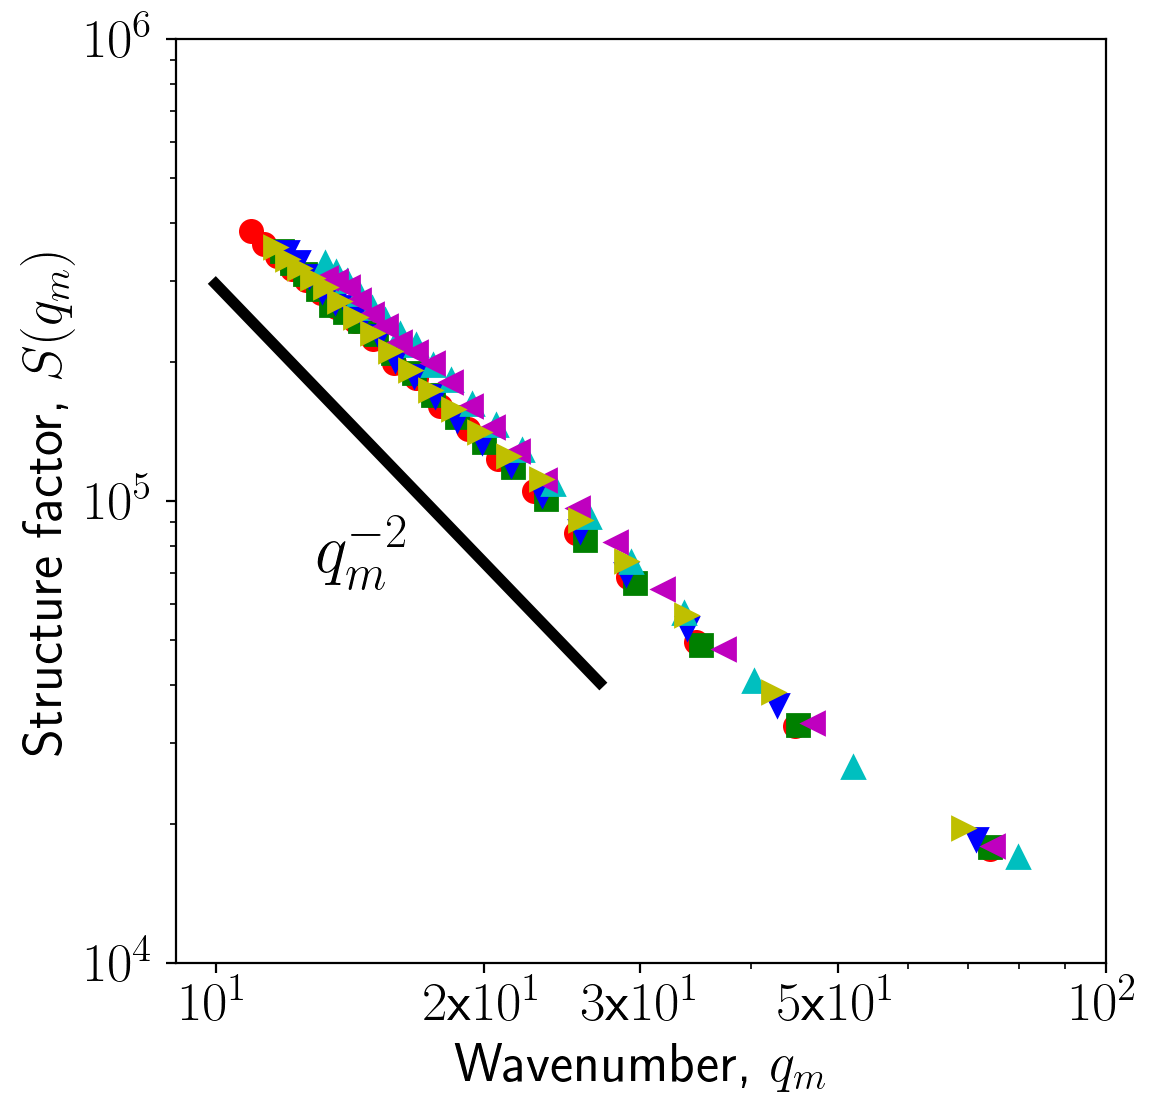

In [9]:
# plot the power law fit Sqm over qm
plt.rc('text', usetex=True)
f, ax = plt.subplots(figsize=(6, 6)) 

markers = ["o", 's', "v" , "^" , "<", ">"]
colors = ['r','g','b','c','m', 'y']

for i in range(6):
    plt.loglog(np.array(qm_avg_meta[i]), np.array(sqm_avg_meta[i]),\
              markers[i] + colors[i], markersize = 8)
plt.loglog(np.array(range(10, 28)), np.exp(17.2)*np.array(range(10, 28))**(-2.),
           'k-', linewidth=4)

plt.xticks((1e1,2e1,3e1,5e1, 1e2), ('$10^{1}$','$2$x$10^{1}$','$3$x$10^{1}$','$5$x$10^{1}$', '$10^{2}$'), color='k', size=20)
plt.yticks((1e4,1e5,1e6), ('$10^{4}$', '$10^{5}$', '$10^{6}$'), size=20)

plt.xlabel('Wavenumber, $q_{m}$', size = 20)
plt.ylabel('Structure factor, $S(q_{m})$', size = 20)

plt.text(13., 7e4, '$q_{m}^{-2}$', {'color': 'k', 'fontsize': 25})

plt.show()
#f.savefig('coarsening_Sqm_qm-log.pdf', dpi=500)  

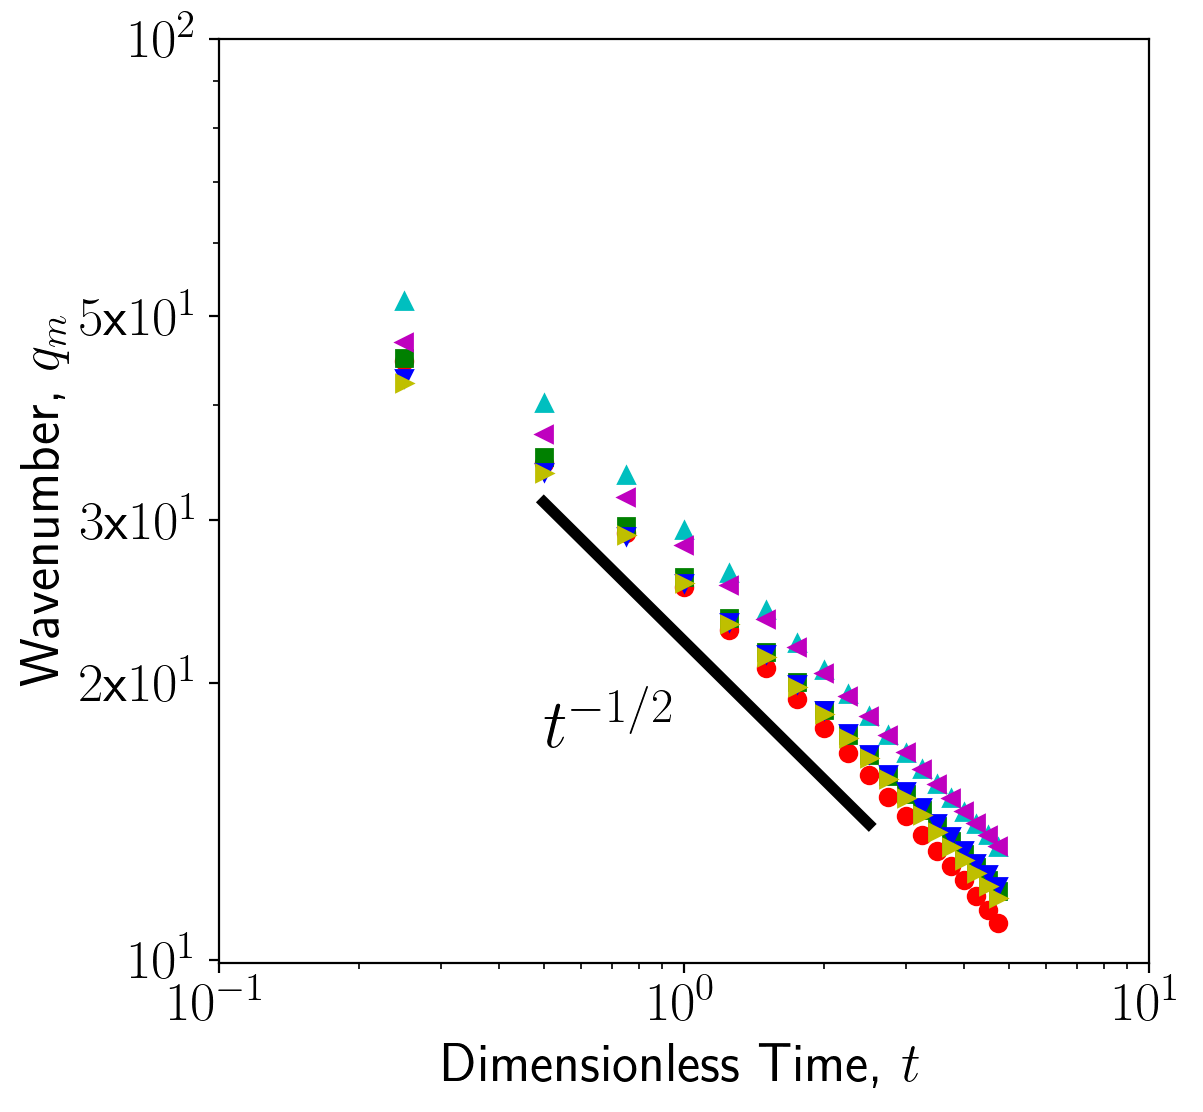

In [10]:
# plot the power law fit qm over t
f, ax = plt.subplots(figsize=(6, 6)) 

markers = ["o", 's', "v" , "^" , "<", ">"]
colors = ['r','g','b','c','m', 'y']

for i in range(6):
    plt.loglog(np.array(tarray_meta[i]), np.array(qm_avg_meta[i]),\
              markers[i] + colors[i], markersize = 6)
plt.loglog(np.linspace(0.5, 2.5, 20), np.exp(3.1)*np.linspace(0.5, 2.5, 20)**(-0.5),\
           'k-', linewidth=4)

plt.xticks((1e-1,1e0, 1e1), ('$10^{-1}$','$10^{0}$', '$10^{1}$'), size=20)
plt.yticks((1e1,2e1,3e1,5e1, 1e2), ('$10^{1}$','$2$x$10^{1}$','$3$x$10^{1}$','$5$x$10^{1}$', '$10^{2}$'), size=20)

plt.text(0.5, 17, '$t^{-1/2}$', {'color': 'k', 'fontsize': 25})

plt.xlabel('Dimensionless Time, $t$', size = 20)
plt.ylabel('Wavenumber, $q_{m}$', size = 20)

plt.show()
#f.savefig('coarsening_qm_t-log.pdf', dpi=300)  

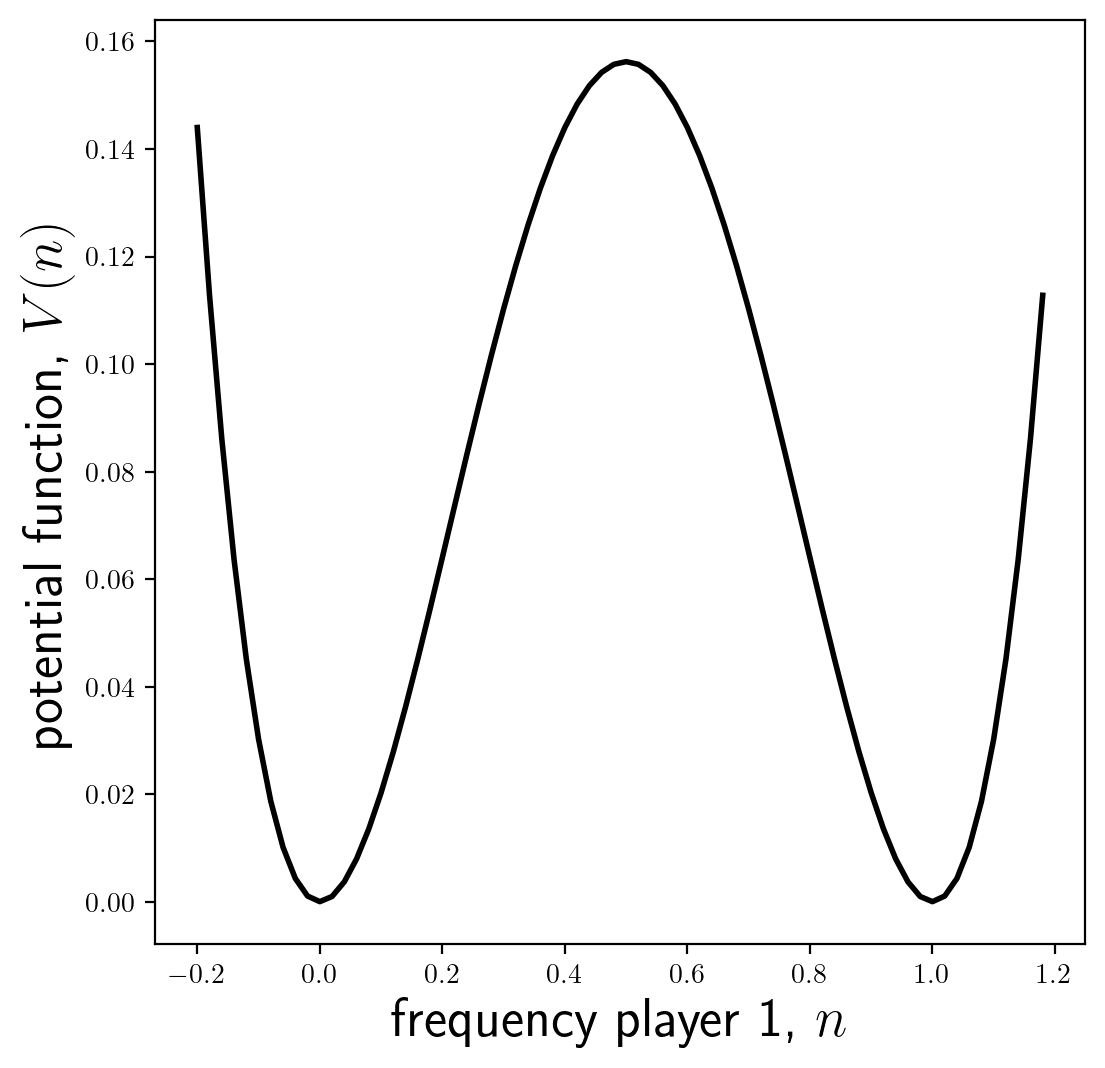

In [12]:
# plot the potential function
f, ax = plt.subplots(figsize=(6, 6)) 
x = np.arange(-0.2, 1.2, 0.02)
a = (A[0,0] - A[1,0]) 
b = (A[0,1] - A[1,1])
V = (1/4)*(a - b)*x**4 + (1/3)*(2*b - a)*x**3 - (1/2)*b*x**2 
plt.plot(x, V, 'k-', linewidth=2)
plt.xlabel('frequency player 1, $n$', size = 20)
plt.ylabel('potential function, $V(n)$', size = 20)


plt.show()
#f.savefig('potential_symmetric.pdf', dpi=300)  